In [ ]:
# default_exp mcmc

# MCMC (using emcee package)

In [ ]:
#export
import emcee
from scipy.stats import distributions as D
import numpy as np
import pylab as py
import matplotlib.pyplot as pl
import scipy.optimize as op
from scipy.special import logsumexp

## Useful Functions

In [ ]:
#export
def histogram(y,bins=50,plot=True):
    N,bins=np.histogram(y,bins)
    
    dx=bins[1]-bins[0]
    if dx==0.0:  #  all in 1 bin!
        val=bins[0]
        bins=np.linspace(val-np.abs(val),val+np.abs(val),50)
        N,bins=np.histogram(y,bins)
    
    dx=bins[1]-bins[0]
    x=bins[0:-1]+(bins[1]-bins[0])/2.0
    
    y=N*1.0/np.sum(N)/dx
    
    if plot:
        py.plot(x,y,'o-')
        yl=py.gca().get_ylim()
        py.gca().set_ylim([0,yl[1]])
        xl=py.gca().get_xlim()
        if xl[0]<=0 and xl[0]>=0:    
            py.plot([0,0],[0,yl[1]],'k--')

    return x,y


def corner(samples,labels):
    N=len(labels)
    from matplotlib.colors import LogNorm
    
    py.figure(figsize=(12,12))
    
    axes={}
    for i,l1 in enumerate(labels):
        for j,l2 in enumerate(labels):
            if j>i:
                continue
                
            ax = py.subplot2grid((N,N),(i, j))
            axes[(i,j)]=ax
            
            idx_y=labels.index(l1)
            idx_x=labels.index(l2)
            x,y=samples[:,idx_x],samples[:,idx_y]
            
            if i==j:
                # plot distributions
                xx,yy=histogram(x,bins=200,plot=False)
                py.plot(xx,yy,'-o',markersize=3)
                py.gca().set_yticklabels([])
                
                if i==(N-1):
                    py.xlabel(l2)
                    [l.set_rotation(45) for l in ax.get_xticklabels()]
                else:
                    ax.set_xticklabels([])
                
            else:
                counts,ybins,xbins,image = py.hist2d(x,y,bins=100,norm=LogNorm())
                #py.contour(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3)
                
                if i==(N-1):
                    py.xlabel(l2)
                    [l.set_rotation(45) for l in ax.get_xticklabels()]
                else:
                    ax.set_xticklabels([])
                    
                if j==0:
                    py.ylabel(l1)
                    [l.set_rotation(45) for l in ax.get_yticklabels()]
                else:
                    ax.set_yticklabels([])
    
    # make all the x- and y-lims the same
    j=0
    lims=[0]*N
    for i in range(1,N):
        ax=axes[(i,0)]
        lims[i]=ax.get_ylim()

        if i==N-1:
            lims[0]=ax.get_xlim()
    
        
    for i,l1 in enumerate(labels):
        for j,l2 in enumerate(labels):
            if j>i:
                continue
                
            ax=axes[(i,j)]
            
            if j==i:
                ax.set_xlim(lims[i])
            else:
                ax.set_ylim(lims[i])
                ax.set_xlim(lims[j])


greek=['alpha','beta','gamma','delta','chi','tau',
        'sigma','lambda','epsilon','zeta','xi','theta','rho','psi']

def timeit(reset=False):
    import time
    global _timeit_data
    try:
        _timeit_data
    except NameError:
        _timeit_data=time.time()
        
    if reset:
        _timeit_data=time.time()

    else:
        return time2str(time.time()-_timeit_data)

def time2str(tm):
    
    frac=tm-int(tm)
    tm=int(tm)
    
    s=''
    sc=tm % 60
    tm=tm//60
    
    mn=tm % 60
    tm=tm//60
    
    hr=tm % 24
    tm=tm//24
    dy=tm

    if (dy>0):
        s=s+"%d d, " % dy

    if (hr>0):
        s=s+"%d h, " % hr

    if (mn>0):
        s=s+"%d m, " % mn


    s=s+"%.2f s" % (sc+frac)

    return s
    
    
def dicttable(D):
    buf=[]
    add=buf.append
    add('<table>')
 
    for key in D:
        add('<tr><td><b>%s</b></td><td>%s</td></tr>' % (key,D[key]))
        
    add('</table>')
    return '\n'.join(buf) 

## Distributions -- Defined for Speed

In [ ]:
#export
import scipy.optimize as op
from scipy.special import gammaln,gamma
def lognchoosek(N,k):
    return gammaln(N+1)-gammaln(k+1)-gammaln((N-k)+1)

def loguniformpdf(x,mn,mx):
    if mn < x < mx:
        return np.log(1.0/(mx-mn))
    return -np.inf

def logjeffreyspdf(x):
    if x>0.0:
        return -np.log(x)
    return -np.inf

def logexponpdf(x,_lambda):
    # p(x)=l exp(l x)
    return _lambda*x + np.log(_lambda)

def logcauchypdf(x,x0,scale):
    return -np.log(np.pi)-np.log(scale)-np.log(1 + ((x-x0)/scale)**2)

def loghalfcauchypdf(x,x0,scale):
    try:
        N=len(x)
    except TypeError:
        N=1

    if x<=0:
        return -np.inf

    return -np.log(np.pi)-np.log(scale)-np.log(1 + ((x-x0)/scale)**2)

def loghalfnormalpdf(x,sig):
    # x>0: 2/sqrt(2*pi*sigma^2)*exp(-x^2/2/sigma^2)
    try:
        N=len(x)
    except TypeError:
        N=1
    if x<=0:
        return -np.inf
        
    return np.log(2)-0.5*np.log(2*np.pi*sig**2)*N - np.sum(x**2/sig**2/2.0)


def lognormalpdf(x,mn,sig,all_positive=False):
    # 1/sqrt(2*pi*sigma^2)*exp(-x^2/2/sigma^2)
    try:
        N=len(x)
        val=-0.5*np.log(2*np.pi*sig**2)*N - np.sum((x-mn)**2/sig**2/2.0)
        if all_positive:
            val[x<0]=-np.inf
        # print(x,mn,val)
        # raise ValueError("here")
        return val
    except TypeError:
        N=1
        # print(x,mn)
        # raise ValueError("there")
        val=-0.5*np.log(2*np.pi*sig**2)*N - np.sum((x-mn)**2/sig**2/2.0)
        if all_positive and x<0:
            val=-np.inf

        return val
    
def logbetapdf(theta, h, N):
    return lognchoosek(N,h)+np.log(theta)*h+np.log(1-theta)*(N-h)

def loglognormalpdf(x,mn,sig):
    if x<=0.0:
        return -np.inf

    # 1/sqrt(2*pi*sigma^2)*exp(-x^2/2/sigma^2)
    try:
        N=len(x)
    except TypeError:
        N=1

    return -0.5*np.log(2*np.pi*sig**2)*N -np.log(x) - np.sum((np.log(x)-mn)**2/sig**2/2.0)


## Distribution Classes

In [ ]:
#export
class Normal(object):
    def __init__(self,mean=0,std=1,all_positive=False):
        self.mean=mean
        self.std=std
        self.default=mean
        self.all_positive=all_positive
        
    def rand(self,*args):

        return np.random.randn(*args)*self.std+self.mean
    
    def __call__(self,x):
        return lognormalpdf(x,self.mean,self.std,self.all_positive)

    def __str__(self):
        return "Normal(%g,%g)" % (self.mean,self.std)

class Exponential(object):
    def __init__(self,_lambda=1):
        self._lambda=_lambda

    def rand(self,*args):
        return np.random.rand(*args)*2
        
    def __call__(self,x):
        return logexponpdf(x,self._lambda)


class Uniform(object):
    def __init__(self,min=0,max=1):
        self.min=min
        self.max=max
        self.default=(min+max)/2.0
       
    def rand(self,*args):
        return np.random.rand(*args)*(self.max-self.min)+self.min
        
    def __call__(self,x):
        return loguniformpdf(x,self.min,self.max)

    def __str__(self):
        return "Uniform(%g,%g)" % (self.min,self.max)


class Jeffreys(object):
    def __init__(self):
        self.default=1.0
        
    def rand(self,*args):
        return np.random.rand(*args)*2
        
    def __call__(self,x):
        return logjeffreyspdf(x)

    def __str__(self):
        return "Jeffreys()"

class HalfCauchy(object):
    def __init__(self,x0=0,scale=1):
        self.x0=x0
        self.scale=scale
        self.default=x0

    @property
    def D(self):
        return D.halfcauchy(loc=self.x0,scale=self.scale) 

    def rand(self,*args):
        return np.random.rand(*args)*2
        
    def __call__(self,x):
        return loghalfcauchypdf(x,self.x0,self.scale)


class HalfNormal(object):
    def __init__(self,sigma=1):
        self.sigma=sigma

    @property
    def D(self):
        return D.halfnorm(self.sigma)

    def rand(self,*args):
        return np.random.rand(*args)*2
        
    def __call__(self,x):
        return loghalfnormalpdf(x,self.sigma)


class LogNormal(object):
    def __init__(self,mean=0,std=1):
        self.mean=mean
        self.std=std
        self.default=mean
        
    @property
    def D(self):
        return D.lognorm(self.mean,self.std)

    def rand(self,*args):
        return np.random.randn(*args)*self.std+self.mean
    
    def __call__(self,x):
        return loglognormalpdf(x,self.mean,self.std)


class Cauchy(object):
    def __init__(self,x0=0,scale=1):
        self.x0=x0
        self.scale=scale
        self.default=x0

    @property
    def D(self):
        return D.cauchy(loc=self.x0,scale=self.scale) 

    def rand(self,*args):
        return np.random.rand(*args)*2-1
        
    def __call__(self,x):
        return logcauchypdf(x,self.x0,self.scale)


class Beta(object):
    def __init__(self,h=100,N=100):
        self.h=h
        self.N=N
        self.default=float(h)/N

    def rand(self,*args):
        return np.random.rand(*args)
        
    def __call__(self,x):
        return logbetapdf(x,self.h,self.N)
    
    def __str__(self):
        return "Beta(h=%g,N=%g)" % (self.h,self.N)
    

## Emcee functions

In [ ]:
#export
def lnprior_function(model):
    def _lnprior(x):
        return model.lnprior(x)

    return _lnprior



In [ ]:
#export
class MCMCModel(object):
    
    def __str__(self):
        s="Simulation:\n"
        s+="\t"+'\n\t'.join(self.sim.equations().split('\n'))
        s+="\nStats Model:\n"
        for key in self.params:
            s+="\t %s = %s" % (key,str(self.params[key]))+"\n"
        return s


    def __init__(self,sim,**kwargs):
        self.sim=sim
        self.params=kwargs
        
        self._init_params_()
       
        self.nwalkers=100
        self.burn_percentage=0.25
        self.initial_value=None
        self.last_pos=None

        self.verbose=True

    def _init_params_(self):
        sim=self.sim
        params=self.params

        self.keys=[]
        for key in self.params:
            self.keys.append(key)
            
        self.data_components={}
        for c in self.sim.components+self.sim.assignments:
            if c.data:
                key='_sigma_%s' % c.name
                if not key in self.params:
                    self.params[key]=Jeffreys()
                    self.keys.append(key)
                self.data_components[c.name]=c
        
        self.index={}
        for i,key in enumerate(self.keys):
            self.index[key]=i

        self.sim_param_keys=[]
        self.initial_value_keys=[]
        self.sigma_keys=[]
        self.initial_components={}
        
        for key in self.keys:
            if key.startswith('_sigma_'):
                self.sigma_keys.append(key)
            elif key.startswith('initial_'):
                self.initial_value_keys.append(key)
                
                name=key.split('initial_')[1]
                try:
                    _c=sim.get_component(name)
                except IndexError:
                    raise ValueError("%s is a bad initial variable because %s is not a variable in the dynamical model." % (key,name))
                self.initial_components[key]=_c

            else:
                self.sim_param_keys.append(key)
                if not key in sim.original_params:
                    raise ValueError("%s is not a parameter in the dynamical model.  Parameters are %s" % (key,str(sim.original_params)))
 

    # Define the probability function as likelihood * prior.
    def lnprior(self,theta):        
        value=0.0
        for i,key in enumerate(self.keys):
            value+=self.params[key](theta[i])
                
        return value

    def lnlike(self,theta):
        
        # set the parameters
        params={}
        for key in self.sim_param_keys:
            params[key]=theta[self.index[key]]
        self.sim.params(**params)
        
        # set the initial values
        for key in self.initial_value_keys:
            self.initial_components[key].initial_value=theta[self.index[key]]
        
            
        # run the sim
        self.sim.run_fast()
        
        # compare with data
        
        value=0.0
        for name in self.data_components:
            key='_sigma_%s' % name
            _c=self.data_components[name]
            sigma=theta[self.index[key]]
            
            t=np.array(_c.data['t']).ravel()
            y=np.array(_c.data['value']).ravel()
            y_fit=self.sim.interpolate(t,name)

            if any(np.isnan(y_fit)):
                return -np.inf

            if any(abs(y_fit)>1e100):
                return -np.inf
                

            value+=lognormalpdf(y,y_fit,sigma)
            # print(sigma)
            # print(y.__repr__())
            # print(y_fit.__repr__())
            # print(theta)
            # raise ValueError
            
        return value
    
    def assign_sim_values(self,theta):
        # set the parameters
        params={}
        for key in self.sim_param_keys:
            params[key]=theta[self.index[key]]
        self.sim.params(**params)
        
        # set the initial values
        for key in self.initial_value_keys:
            self.initial_components[key].initial_value=theta[self.index[key]]
        
        
    def lnlike_lownoise(self,theta):
        
        self.assign_sim_values(theta)        
        
        # run the sim
        self.sim.run_fast()
        
        # compare with data
        
        value=0.0
        for name in self.data_components:
            key='_sigma_%s' % name
            _c=self.data_components[name]
            sigma=theta[self.index[key]]
            
            t=_c.data['t'].ravel()
            y=_c.data['value'].ravel()
            y_fit=self.sim.interpolate(t,name)
            value+=lognormalpdf(y,y_fit,1.0)  # replace sigma with 1.0
            
        return value

    def lnprob(self,theta):
        lp = self.lnprior(theta)
        if np.isnan(lp):
            return -np.inf

        if not np.isfinite(lp):
            return -np.inf

        lnl=self.lnlike(theta)  
        if np.isnan(lnl):
            return -np.inf
            
        return lp + lnl      

    def __call__(self,theta):
        return self.lnprob(theta)
    
    def set_initial_values(self,method='prior',*args,**kwargs):
        if isinstance(method,(list,np.ndarray)):
            ndim=len(self.params)
            vals=method
            self.last_pos=array(vals)
            assert self.last_pos.shape==(self.nwalkers,ndim)
        elif method=='sim':
            self.initial_value=np.ones(len(self.params))
            
            for key in self.sim_param_keys:
                self.initial_value[self.index[key]]=self.sim.myparams[key]
            
            for key in self.initial_value_keys:
                _c=self.initial_components[key]
                self.initial_value[self.index[key]]=_c.initial_value
            self.last_pos=emcee.utils.sample_ball(self.initial_value, 0.05*self.initial_value+1e-4, size=self.nwalkers)
        elif method=='samples':
            lower,upper=np.percentile(self.samples, [16,84],axis=0)            
            subsamples=self.samples[((self.samples>=lower) & (self.samples<=upper)).all(axis=1),:]
            idx=np.random.randint(subsamples.shape[0],size=self.last_pos.shape[0])
            self.last_pos=subsamples[idx,:]            
        elif method=='prior':
            ndim=len(self.params)
            try:
                N=args[0]
            except IndexError:
                N=300

            pos=np.zeros((self.nwalkers,ndim))
            for i,key in enumerate(self.keys):
                pos[:,i]=self.params[key].rand(100)

            
            self.sampler = emcee.EnsembleSampler(self.nwalkers, ndim, 
                    lnprior_function(self))

            if self.verbose:
                timeit(reset=True)
                print("Sampling Prior...")

            self.sampler.run_mcmc(pos, N,**kwargs)

            if self.verbose:
                print("Done.")
                print(timeit())

            # assign the median back into the simulation values
            self.burn()
            self.median_values=np.percentile(self.samples,50,axis=0)

            self.last_pos=self.sampler.chain[:,-1,:]

        elif method=='maximum likelihood':
            self.initial_value=zeros(len(self.params))
            
            for key in self.sim_param_keys:
                self.initial_value[self.index[key]]=self.sim.myparams[key]
            
            for key in self.initial_value_keys:
                _c=self.initial_components[key]
                self.initial_value[self.index[key]]=_c.initial_value
            
            for key in self.sigma_keys:
                self.initial_value[self.index[key]]=1.0
            
            chi2 = lambda *args: -2 * self.lnlike_lownoise(*args)
            result = op.minimize(chi2, self.initial_value)
            vals=result['x']
            self.initial_value=array(vals)
            self.last_pos=emcee.utils.sample_ball(self.initial_value, 0.05*self.initial_value+1e-4, size=self.nwalkers)
            
        else:
            raise ValueError("Unknown method: %s" % method)

                    
    
    def burn(self,burn_percentage=None):
        if not burn_percentage is None:
            self.burn_percentage=burn_percentage
            
        burnin = int(self.sampler.chain.shape[1]*self.burn_percentage)  # burn 25 percent
        ndim=len(self.params)
        self.samples = self.sampler.chain[:, burnin:, :].reshape((-1, ndim))
        
    
    def run_mcmc(self,N,repeat=1,**kwargs):
        
        ndim=len(self.params)
        
        if self.last_pos is None:
            self.set_initial_values()
        
        self.real_initial_value=self.last_pos.copy()
        

        for i in range(repeat):
            self.sampler = emcee.EnsembleSampler(self.nwalkers, ndim, self,)

            if self.verbose:
                timeit(reset=True)
                print("Running MCMC %d/%d..." % (i+1,repeat))

            self.sampler.run_mcmc(self.last_pos, N,**kwargs)

            if self.verbose:
                print("Done.")
                print(timeit())

        
            # assign the median back into the simulation values
            self.burn()
            self.median_values=np.percentile(self.samples,50,axis=0)
            theta=self.median_values

        

            self.assign_sim_values(theta)
            self.initial_value=theta
            self.last_pos=self.sampler.chain[:,-1,:]


            if repeat>1:
                self.set_initial_values('samples')  # reset using the 16-84 percentile values from the samples

        # calculate BIC
        k=len(theta)
        N=0
        for name in self.data_components:
            key='_sigma_%s' % name
            _c=self.data_components[name]
            sigma=theta[self.index[key]]
            
            t=_c.data['t']
            y=_c.data['value']

            N+=len(y)


        # lower BIC = good
        
        self.BIC=k * np.log(N)-2.0*self.lnlike(theta)

        # ΔBIC    Evidence against higher BIC
        # 0 to 2  Not worth more than a bare mention
        # 2 to 6  Positive
        # 6 to 10 Strong
        # >10 Very Strong


        return self.summary()
    
    def summary(self):
        from IPython.display import HTML
        buf=[]
        add=buf.append

        def tds(L):
            return ' '.join([f'<td>{s}</td>' for s in L])
        def b(s):
            s=str(s)
            return f"<b>{s}</b"

        add('<h1>Priors</h1>')
        add('<table>')

        row=[]
        td=row.append

        td(b("name"))
        td(b("prior"))
        td(b(" "))

        add('<tr>%s</tr>' % (tds(row)))
        for p in self.params:
            typestr=str(type(self.params[p])).split("'")[1].split(".")[-1]

            row=[]
            td=row.append

            td(b(p))
            td(typestr)

            if typestr=='Uniform':
                td(dicttable(
                    {'min':self.params[p].min,
                     'max':self.params[p].max}))
            else:
                td(dicttable({}))

            add('<tr>%s</tr>' % (tds(row)))

        add('</table>')

        add('<h1>Fit Statistics</h1>')

        N=sum([len(c.data['value']) for c in model.sim.components if c.data])
        fit_stats={'data points':N,
                   'variables':len(model.params),
                   'number of walkers':model.nwalkers,
                   'number of samples':model.samples.shape[0],
                  'Bayesian info crit. (BIC)':model.BIC}
        add(dicttable(fit_stats))



        add('<h1>Posteriors</h1>')
        add('<table>')

        row=[]
        td=row.append

        td(b("name"))
        td(b("value"))
        td(b("2.5%"))
        td(b("97.5%"))

        add('<tr>%s</tr>' % (tds(row)))

        pp=self.percentiles([0.025,50,97.5])
        for p in self.params:
            typestr=str(type(self.params[p])).split("'")[1].replace('pyndamics3.mcmc.','')

            row=[]
            td=row.append

            td(b(p))
            td(f'{pp[p][1]:.5g}')
            td(f'{pp[p][0]:.5g}')
            td(f'{pp[p][2]:.5g}')

            add('<tr>%s</tr>' % (tds(row)))

        add('</table>')


        return HTML('\n'.join(buf))
        #return '\n'.join(buf)

    def WAIC(self):
        # WAIC
        # from https://github.com/pymc-devs/pymc3/blob/02f0b7f9a487cf18e9a48b754b54c2a99cf9fba8/pymc3/stats.py
        # We get three different measurements:
        # waic: widely available information criterion
        # waic_se: standard error of waic
        # p_waic: effective number parameters

        log_py=np.atleast_2d(array([self.lnprob(theta) 
                                        for theta in self.samples])).T
        lppd_i = logsumexp(log_py, axis=0, b=1.0 / len(log_py))
        vars_lpd = np.var(log_py, axis=0)
        warn_mg = 0
        if np.any(vars_lpd > 0.4):
            warnings.warn("""For one or more samples the posterior variance of the
            log predictive densities exceeds 0.4. This could be indication of
            WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
            """)
            warn_mg = 1

        waic_i = - 2 * (lppd_i - vars_lpd)
        waic = np.sum(waic_i)
        waic_se = np.sqrt(len(waic_i) * np.var(waic_i))
        p_waic = np.sum(vars_lpd)            

        self.waic={'waic': waic,
                   'waic_se':waic_se,
                   'p_waic':p_waic,
        }

        return waic,waic_se,p_waic

    def plot_chains(self,*args,**kwargs):
        pl.clf()
        
        if not args:
            args=self.keys
        
        
        fig, axes = pl.subplots(len(self.params), 1, sharex=True, figsize=(8, 5*len(args)))

        labels=[]
        for ax,key in zip(axes,args):
            i=self.index[key]
            sample=self.sampler.chain[:, :, i].T

            if key.startswith('_sigma_'):
                name=key.split('_sigma_')[1]
                label=r'$\sigma_{%s}$' % name
            else:
                namestr=key
                for g in greek:
                    if key.startswith(g):
                        namestr=r'\%s' % key

                label='$%s$' % namestr

            labels.append(label)
            ax.plot(sample, color="k", alpha=0.2,**kwargs)
            ax.set_ylabel(label)

            
    def triangle_plot(self,*args,**kwargs):
        
        if not args:
            args=self.keys
            
        assert len(args)>1
        
        labels=[]
        idx=[]
        for key in args:
            if key.startswith('_sigma_'):
                name=key.split('_sigma_')[1]
                label=r'$\sigma_{%s}$' % name
            else:
                namestr=key
                for g in greek:
                    if key.startswith(g):
                        namestr=r'\%s' % key

                label='$%s$' % namestr

            labels.append(label)
            idx.append(self.index[key])
        
        fig = corner(self.samples[:,idx], labels=labels)
        
    def plot_distributions(self,*args,**kwargs):
        if not args and not kwargs:
            keys=list(self.keys)
        else:
            keys=list(args)

        keys=keys+list(kwargs.keys())
        
        for key in keys:

            if type(key)==str:

                if key.startswith('_sigma_'):
                    name=key.split('_sigma_')[1]
                    label=r'\sigma_{%s}' % name
                else:
                    namestr=key
                    for g in greek:
                        if key.startswith(g):
                            namestr=r'\%s' % key

                    label='%s' % namestr
                if key in kwargs:
                    values=kwargs[key]
                else:
                    i=self.index[key]
                    values=self.samples[:,i]
            else:
                values=key
                label='value'


            py.figure(figsize=(12,4))
            result=histogram(values,bins=200)
            xlim=pl.gca().get_xlim()
            x=py.linspace(xlim[0],xlim[1],500)
            y=D.norm.pdf(x,np.median(values),np.std(values))
            py.plot(x,y,'-')

            v=np.percentile(values, [2.5, 50, 97.5],axis=0)

            if v[1]<.005 or (v[2]-v[1])<0.005 or (v[1]-v[0])<0.005:
                py.title(r'$\hat{%s}^{97.5}_{2.5}=%.3g^{+%.3g}_{-%.3g}$' % (label,v[1],(v[2]-v[1]),(v[1]-v[0])))
            else:
                py.title(r'$\hat{%s}^{97.5}_{2.5}=%.3f^{+%.3f}_{-%.3f}$' % (label,v[1],(v[2]-v[1]),(v[1]-v[0])))
            py.ylabel(r'$p(%s|{\rm data})$' % label)

    def eval(self,S):
        for i,key in enumerate(self.keys):
            exec('%s=self.samples[:,i]' % key)
        result=eval(S)
        return result


    
    def get_distribution(self,key,bins=200):
            
        i=self.index[key]
        x,y=histogram(self.samples[:,i],bins=bins,plot=False)
        
        return x,y
        
    def plot_many(self,t_min,t_max,params,N=500,alpha=0.05):
        sim=self.sim
        if isinstance(params,str):
            params=[params]
        
        sim.noplots=True  # turn off the simulation plots
        for i in range(N):
            self.draw()
            sim.run(t_min,t_max)
            for num,p in enumerate(params):
                t=sim.t
                v=sim[p]
                py.figure(num+1)
                py.plot(t,v,'g-',alpha=alpha)
        sim.noplots=False  # gotta love a double-negative
        for num,p in enumerate(params):
            py.figure(num+1)
            c=sim.get_component(p)
            py.ylabel(c.label)
            py.xlabel('time')
            if not c.data:
                continue
            t=c.data['t']
            v=c.data['value']
            py.plot(t,v,'bo')  


    def percentiles(self,p=[16, 50, 84]):
        result={}
        for i,key in enumerate(self.keys):
            result[key]=np.percentile(self.samples[:,i], p,axis=0)
            
        return result
        
    def get_samples(self,*args):
        result=[]

        if not args:
            args=self.keys

        for a in args:
            i=self.keys.index(a)
            result.append(self.samples[:,i])
            
        if len(result)==1:
            return result[0]
        else:
            return result
        
    def best_estimates(self):
        self.median_values=np.percentile(self.samples,50,axis=0)
        theta=self.median_values
        
        self.assign_sim_values(theta)
        return self.percentiles()
        
    def draw(self):
        s=np.random.randint(self.samples.shape[0])
        theta=self.samples[s,:]
        self.assign_sim_values(theta)
        return theta
 


In [ ]:
#export
class MCMCModelReg(MCMCModel):

    def __init__(self,sim,verbose=True,**kwargs):
        super().__init__(sim, **kwargs)
        self.apply_regression(verbose)
        self._init_params_()
        
    def apply_regression(self,verbose=True):
        model=self
        sim=self.sim

        # make a common time variable
        from operator import or_
        from functools import reduce
        t=np.array(sorted(reduce(or_, [set(c.data['t']) for c in sim.components if c.data])))    

        from numpy import gradient,interp    
        from statsmodels.formula.api import ols

        data={'t':t}
        for c in sim.components:
            if not c.data:
                continue

            data[c.name]=interp(t,c.data['t'],c.data['value'])
            data['d%s_dt' % c.name]=gradient(data[c.name],t)            

        if verbose:
            print(data)

        model_results=[]
        for c in sim.components:
            if not c.data:
                continue

            eqn=c.diffstr

            if '-' in eqn:
                raise NotImplementedError("Equation: '%s'" % eqn)

            parts=eqn.split('+')
            param_names=[p.split('*')[0].strip() for p in parts]
            rest=['*'.join(p.split('*')[1:]) for p in parts]

            regeqn="d%s_dt ~ " % c.name
            found_intercept=False
            terms=[]
            for r in rest:
                if not r:  # intercept
                    regeqn+=" +1 "
                    terms.append('Intercept')
                    found_intercept=True
                else:
                    term="I(%s)" % r.strip().replace(' ','')
                    terms.append(term)
                    regeqn+=" +%s " % term

            if not found_intercept:
                regeqn+=" -1 "

            if verbose:
                print("regeqn: ",regeqn)

            model_E = ols(regeqn,data)
            result_E = model_E.fit()

            parse_info={'terms':terms,'param_names':param_names}
            model_results.append((parse_info,model_E,result_E))
            if verbose:
                print(result_E.summary())

            translation={}
            for name in model_E.exog_names:
                idx=terms.index(name.strip().replace(' ',''))
                translation[name]=param_names[idx]
            if verbose:
                print(translation)


            for t in translation:
                p,b=result_E.params[t],result_E.bse[t]
                mn=p
                sd=b*0.5
                model.params[translation[t]]=Normal(mn,sd)
                sim.myparams[translation[t]]=mn
                sim.original_params[translation[t]]=mn

        if verbose:
            print(model)

        self.model_results=model_results



# A linear growth example

Data from [http://www.seattlecentral.edu/qelp/sets/009/009.html](http://www.seattlecentral.edu/qelp/sets/009/009.html)


In [ ]:
from pyndamics3 import Simulation

Text(0, 0.5, 'Height [cm]')

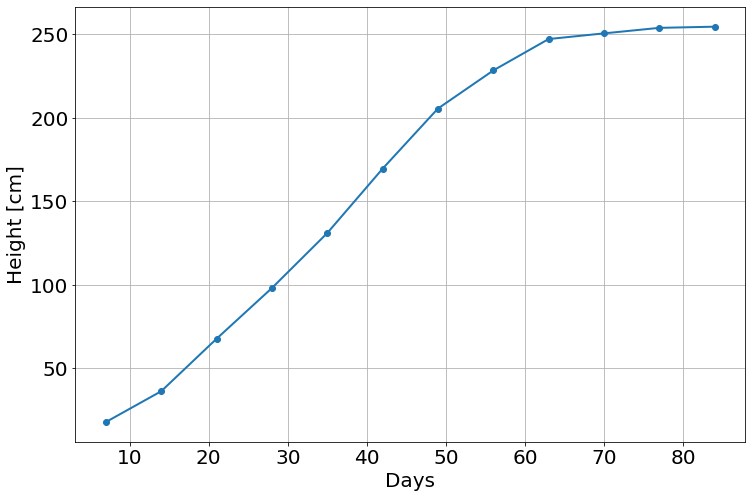

In [ ]:
t=np.array([7,14,21,28,35,42,49,56,63,70,77,84],float)
h=np.array([17.93,36.36,67.76,98.10,131,169.5,205.5,228.3,247.1,250.5,253.8,254.5])

py.plot(t,h,'-o')
py.xlabel('Days')
py.ylabel('Height [cm]')

## Run an initial (and bad) simulation

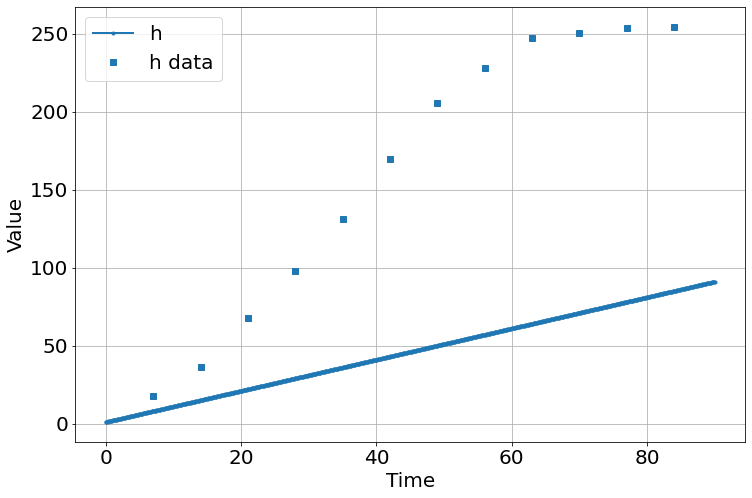

<Figure size 864x576 with 0 Axes>

In [ ]:
sim=Simulation()
sim.add("h'=a",1,plot=True)
sim.add_data(t=t,h=h,plot=True)
sim.params(a=1)
sim.run(0,90)

## Fitting $a$

In [ ]:
model=MCMCModel(sim,a=Uniform(-10,10))

Sampling Prior...
Done.
0.39 s
Running MCMC 1/1...
Done.
40.76 s


<Figure size 864x576 with 0 Axes>

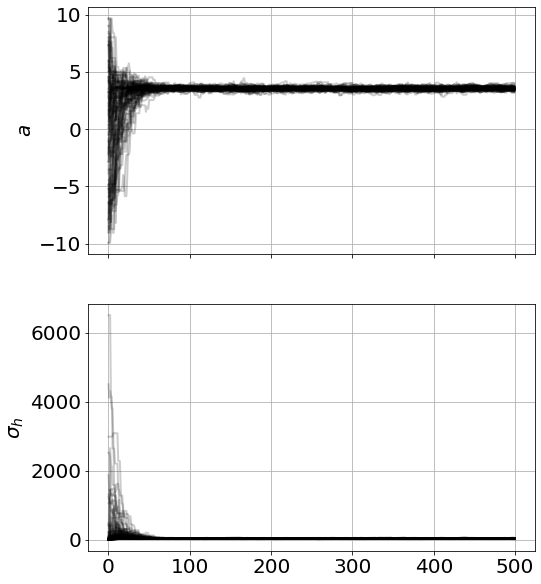

In [ ]:
result=model.run_mcmc(500)
model.plot_chains()

Although this looked converged, you might have situations where you want to repeat the mcmc-resample loop (i.e. resample parameters from the 95% CI of the current samples)

In [ ]:
result

Running MCMC 1/3...
Done.
8.47 s
Running MCMC 2/3...
Done.
8.21 s
Running MCMC 3/3...
Done.
8.20 s


<Figure size 864x576 with 0 Axes>

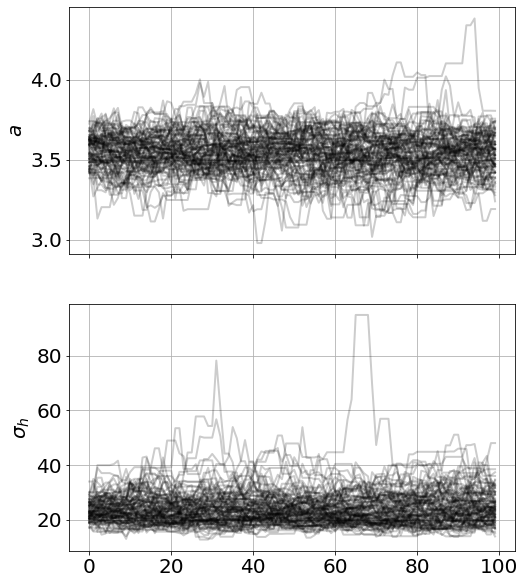

In [ ]:
model.run_mcmc(100,repeat=3)
model.plot_chains()

In [ ]:
model.summary()

In [ ]:
model.best_estimates()

{'a': array([3.41276037, 3.5509136 , 3.6829332 ]),
 '_sigma_h': array([18.50769675, 22.69773539, 28.29713438])}

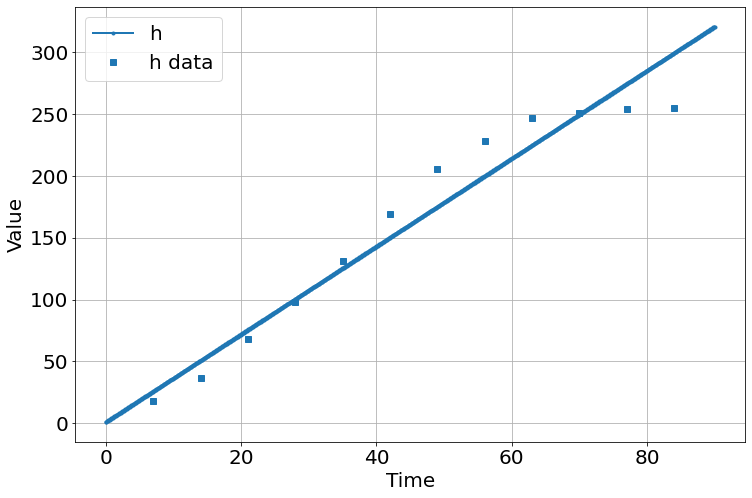

<Figure size 864x576 with 0 Axes>

In [ ]:
sim.run(0,90)

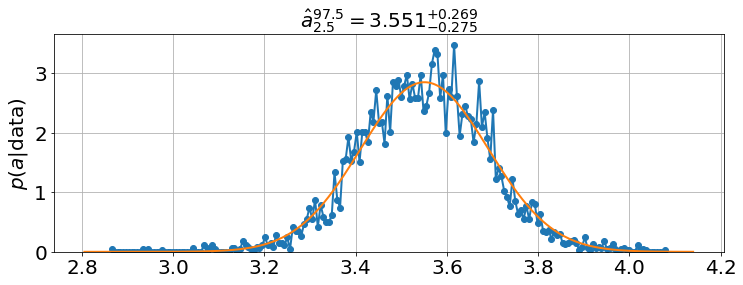

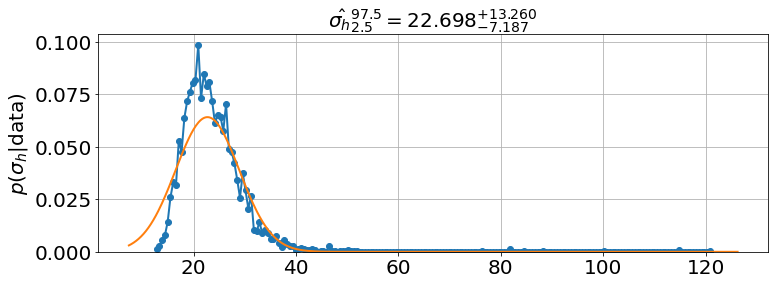

In [ ]:
model.plot_distributions()

## Fitting with $a$ and the initial $h$

In [ ]:
model=MCMCModel(sim,
                a=Uniform(-10,10),
                initial_h=Uniform(0,180),
                )

Sampling Prior...
Done.
0.43 s
Running MCMC 1/2...
Done.
29.34 s
Running MCMC 2/2...
Done.
29.19 s


<Figure size 864x576 with 0 Axes>

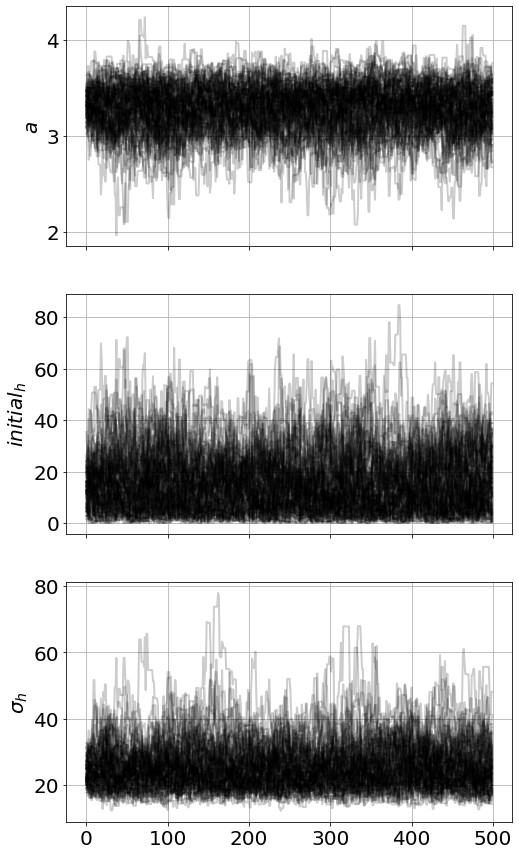

In [ ]:
model.run_mcmc(500,repeat=2)
model.plot_chains()

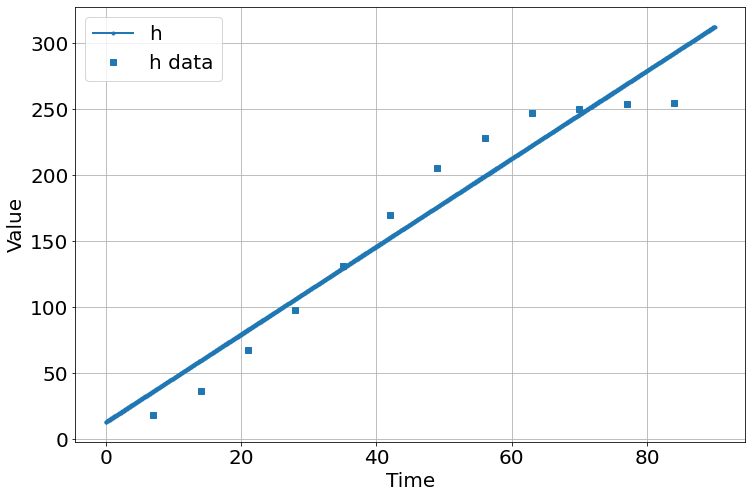

<Figure size 864x576 with 0 Axes>

In [ ]:
sim.run(0,90)

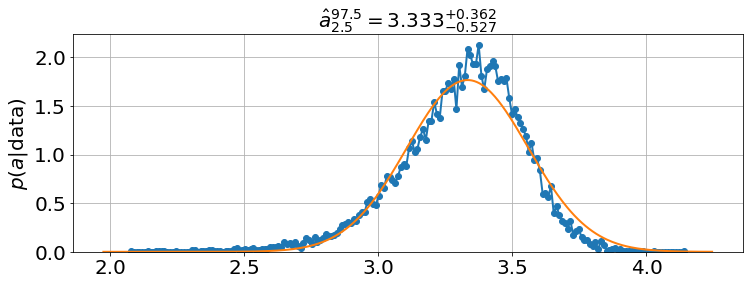

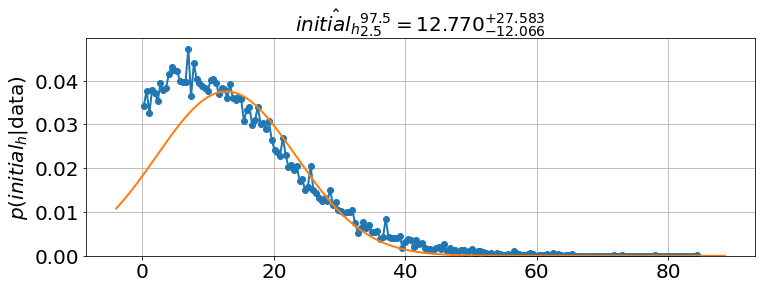

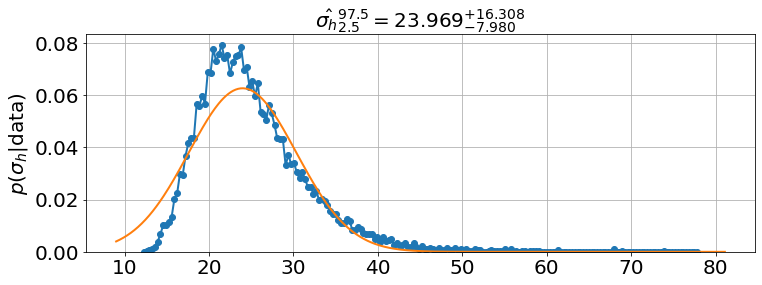

In [ ]:
model.plot_distributions()

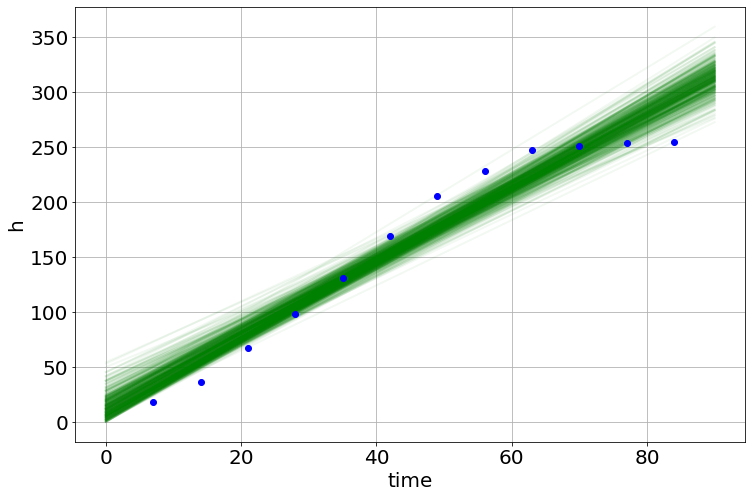

In [ ]:
model.plot_many(0,90,'h')

# Logistic with the Same Data

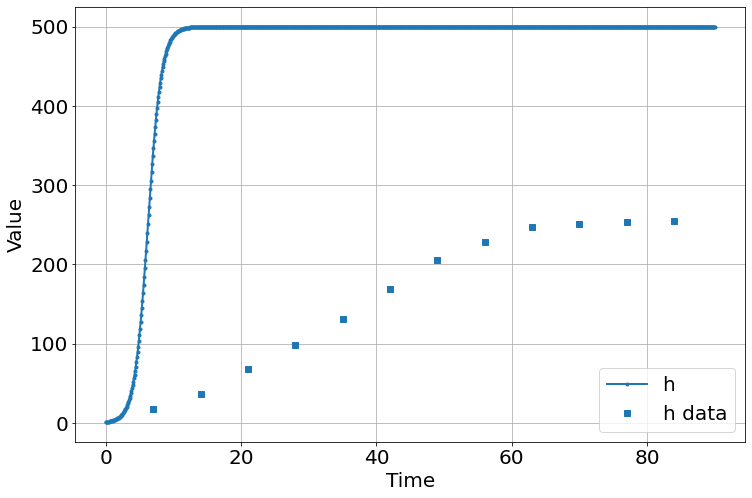

<Figure size 864x576 with 0 Axes>

In [ ]:
t=np.array([7,14,21,28,35,42,49,56,63,70,77,84],float)
h=np.array([17.93,36.36,67.76,98.10,131,169.5,205.5,228.3,247.1,250.5,253.8,254.5])

sim=Simulation()
sim.add("h'=a*h*(1-h/K)",1,plot=True)
sim.add_data(t=t,h=h,plot=True)
sim.params(a=1,K=500)
sim.run(0,90)

In [ ]:
model=MCMCModel(sim,
                a=Uniform(.001,5),
                K=Uniform(100,500),
                initial_h=Uniform(0,100),
                )

Sampling Prior...
Done.
0.43 s
Running MCMC 1/3...
Done.
38.74 s
Running MCMC 2/3...
Done.
48.56 s
Running MCMC 3/3...
Done.
52.50 s


<Figure size 864x576 with 0 Axes>

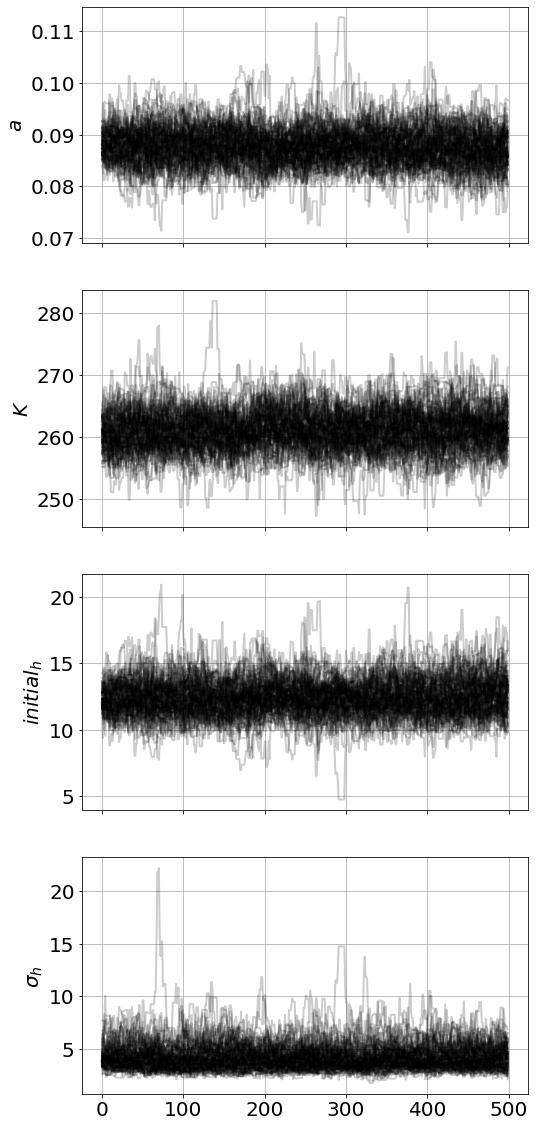

In [ ]:
model.run_mcmc(500,repeat=3)
model.plot_chains()

In [ ]:
model.best_estimates()

{'a': array([0.08452244, 0.08754994, 0.09062923]),
 'K': array([258.46068768, 261.11871483, 263.83119905]),
 'initial_h': array([11.2367951 , 12.3431459 , 13.55099098]),
 '_sigma_h': array([3.12526592, 3.88416891, 5.06139448])}

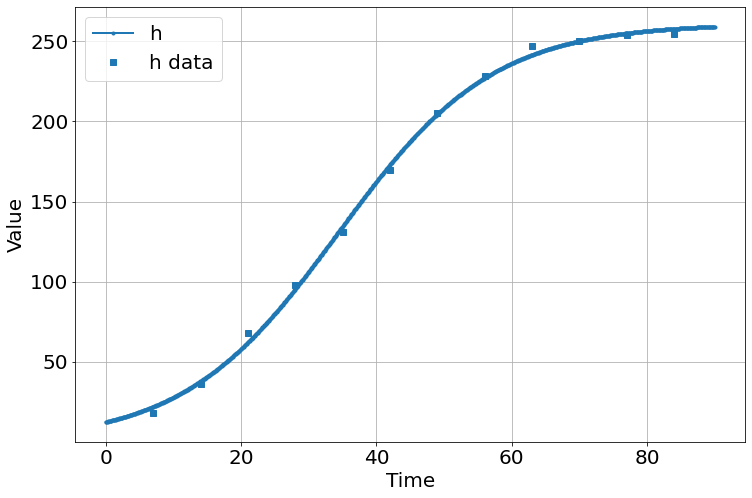

<Figure size 864x576 with 0 Axes>

In [ ]:
sim.run(0,90)

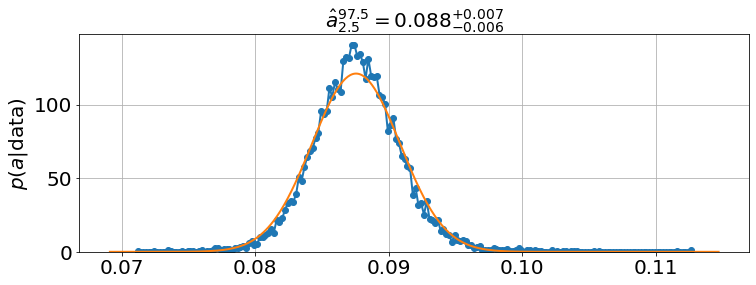

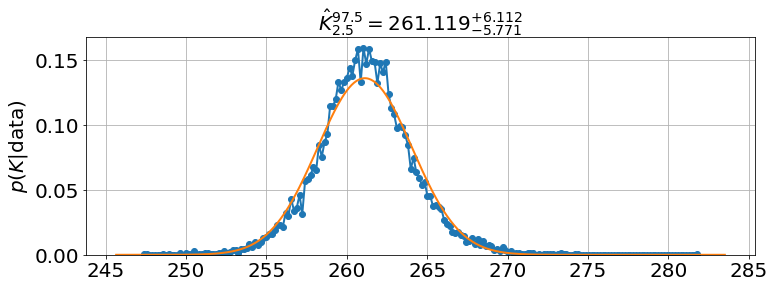

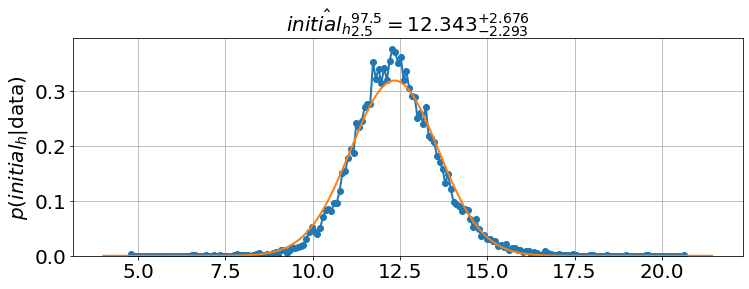

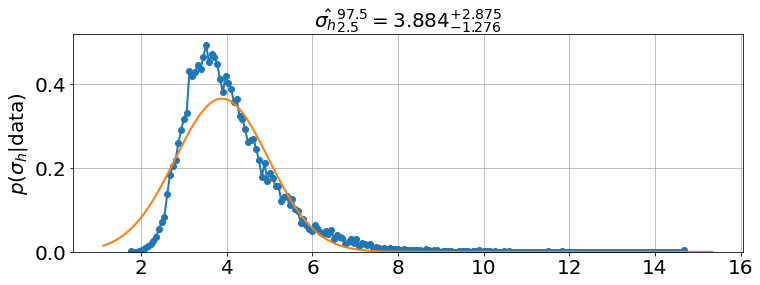

In [ ]:
model.plot_distributions()

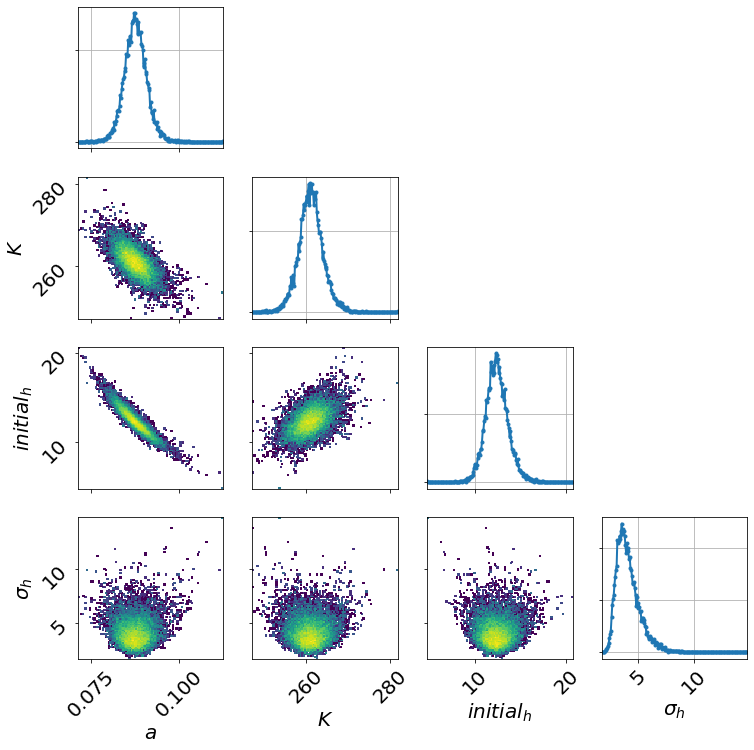

In [ ]:
model.triangle_plot()

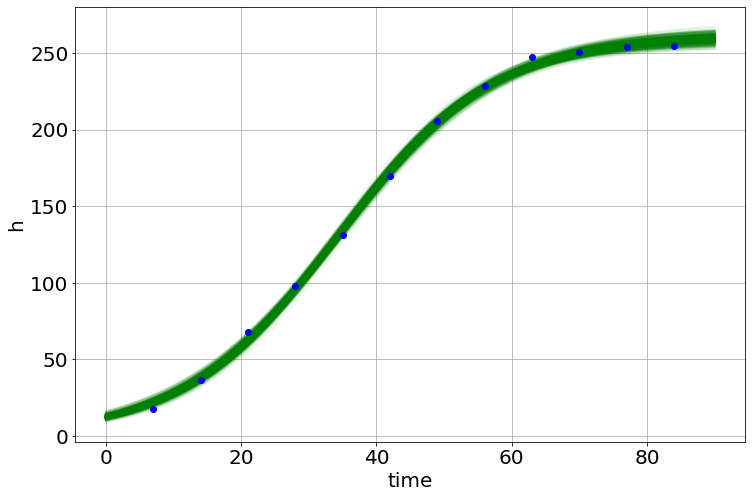

In [ ]:
model.plot_many(0,90,'h')

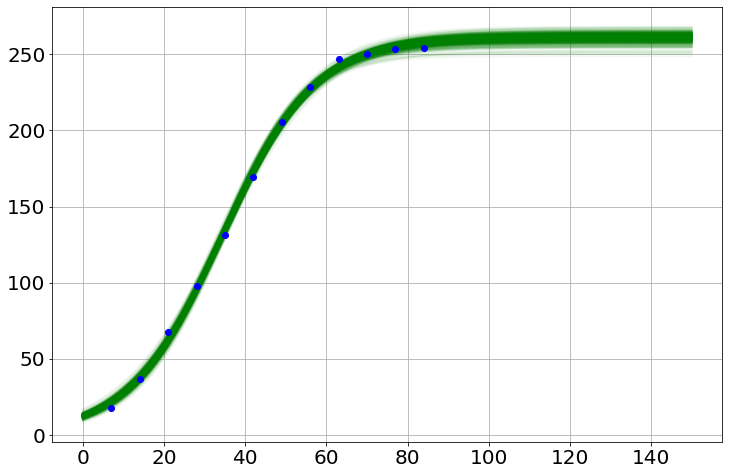

In [ ]:
sim.noplots=True  # turn off the simulation plots
saved_h=[]
for i in range(500):
    model.draw()
    sim.run(0,150)
    py.plot(sim.t,sim.h,'g-',alpha=.05)
    saved_h.append(sim.h)
sim.noplots=False  # gotta love a double-negative
py.plot(t,h,'bo')  # plot the data
saved_h=np.array(saved_h)

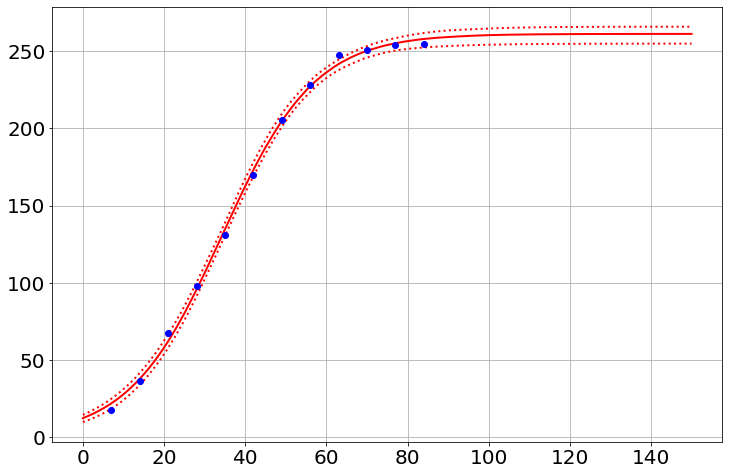

In [ ]:
med=np.percentile(saved_h,50,axis=0)
lower=np.percentile(saved_h,2.5,axis=0)
upper=np.percentile(saved_h,97.5,axis=0)
py.plot(sim.t,med,'r-')
py.plot(sim.t,lower,'r:')
py.plot(sim.t,upper,'r:')

py.plot(t,h,'bo')  # plot the data